# Producto Computacional 3: Modelamiento Predictivo con MHEALTH

**Objetivo:** Aplicar técnicas de Machine Learning o Deep Learning para construir y validar modelos capaces de reconocer actividades humanas a partir de los sensores del dataset MHEALTH.

## 1. Preparación de los Datos

### 1.1. Importar Librerías
Importamos todas las librerías necesarias para la carga, preprocesamiento, modelado y visualización.

In [35]:
import pandas as pd
import numpy as np
import os
import glob  # Para encontrar archivos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modelos (Implementaremos 2 como solicita el .docx)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier 

# Métricas de Validación
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### 1.2. Carga y Concatenación de Datos

Vamos a cargar los 10 archivos `.log`. Basado en la documentación oficial del dataset MHEALTH, los archivos no tienen cabecera y están separados por espacios/tabs. Asignaremos los nombres de columna manualmente.

**Importante:** Añadiremos una columna `subject` a cada DataFrame antes de unirlos, para mantener la trazabilidad de qué sujeto generó cada registro.

In [36]:
# Definimos los nombres de las 24 columnas según la documentación del dataset
column_names = [
    'acc_chest_X', 'acc_chest_Y', 'acc_chest_Z',
    'ecg_lead_1', 'ecg_lead_2',
    'acc_ankle_X', 'acc_ankle_Y', 'acc_ankle_Z',
    'gyro_ankle_X', 'gyro_ankle_Y', 'gyro_ankle_Z',
    'mag_ankle_X', 'mag_ankle_Y', 'mag_ankle_Z',
    'acc_arm_X', 'acc_arm_Y', 'acc_arm_Z',
    'gyro_arm_X', 'gyro_arm_Y', 'gyro_arm_Z',
    'mag_arm_X', 'mag_arm_Y', 'mag_arm_Z',
    'Label'
]

# Ruta a la carpeta de datos (estamos en 'notebooks/', así que subimos un nivel a '../datos/')
data_path = '../datos/'

# Usamos glob para encontrar todos los archivos .log
log_files = glob.glob(os.path.join(data_path, '*.log'))

# Lista para guardar los DataFrames individuales
df_list = []

for file in log_files:
    # Extraemos el nombre del sujeto del nombre del archivo
    subject_name = os.path.basename(file).replace('.log', '')
    
    # Leemos el archivo log. 
    # 'delim_whitespace=True' maneja separadores de tabulación o espacios
    temp_df = pd.read_csv(file, delim_whitespace=True, header=None, names=column_names)
    
    # Añadimos la columna del sujeto
    temp_df['subject'] = subject_name
    
    df_list.append(temp_df)

# Concatenamos todos los DataFrames en uno solo
df_raw = pd.concat(df_list, ignore_index=True)

print(f"Se cargaron {len(df_list)} archivos.")
print(f"Dimensiones del DataFrame total: {df_raw.shape}")

C:\Users\javig\AppData\Local\Temp\ipykernel_13480\2598822833.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  temp_df = pd.read_csv(file, delim_whitespace=True, header=None, names=column_names)
C:\Users\javig\AppData\Local\Temp\ipykernel_13480\2598822833.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  temp_df = pd.read_csv(file, delim_whitespace=True, header=None, names=column_names)
C:\Users\javig\AppData\Local\Temp\ipykernel_13480\2598822833.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  temp_df = pd.read_csv(file, delim_whitespace=True, header=None, names=column_names)
C:\Users\javig\AppData\Local\Temp\ipykernel_13480\2598822833.py:29: FutureWarning: The 'delim_whitespace' keywor

Se cargaron 10 archivos.
Dimensiones del DataFrame total: (1215745, 25)


### 1.3. Preprocesamiento y Limpieza

Revisamos la integridad de los datos (nulos) y la distribución de nuestra variable objetivo (`Label`).

In [37]:
# 1. Revisar valores nulos
print("Valores nulos por columna:")
print(df_raw.isnull().sum())

# 2. Revisar la distribución de la variable 'Label'
print("\nDistribución de la variable 'Label':")
print(df_raw['Label'].value_counts())

Valores nulos por columna:
acc_chest_X     0
acc_chest_Y     0
acc_chest_Z     0
ecg_lead_1      0
ecg_lead_2      0
acc_ankle_X     0
acc_ankle_Y     0
acc_ankle_Z     0
gyro_ankle_X    0
gyro_ankle_Y    0
gyro_ankle_Z    0
mag_ankle_X     0
mag_ankle_Y     0
mag_ankle_Z     0
acc_arm_X       0
acc_arm_Y       0
acc_arm_Z       0
gyro_arm_X      0
gyro_arm_Y      0
gyro_arm_Z      0
mag_arm_X       0
mag_arm_Y       0
mag_arm_Z       0
Label           0
subject         0
dtype: int64

Distribución de la variable 'Label':
Label
0     872550
1      30720
2      30720
3      30720
4      30720
9      30720
5      30720
11     30720
10     30720
7      29441
8      29337
6      28315
12     10342
Name: count, dtype: int64


### ⚠️ **Importante: Filtrado de la 'Clase Nula'**

Al revisar la distribución de 'Label', notarás que la **etiqueta 0** es la más común.

Según la documentación oficial del dataset MHEALTH, la etiqueta `0` corresponde a la "Clase Nula" (actividades no etiquetadas o transiciones). Las actividades reales a clasificar van de la `1` a la `12` (L1 a L12).

Para cumplir con el objetivo de "reconocer actividades humanas", **debemos filtrar y eliminar todos los registros donde `Label == 0`**.

In [38]:
# Filtramos el DataFrame para quedarnos solo con las etiquetas de actividad (1 a 12)
df = df_raw[df_raw['Label'] != 0].copy()

# Verificamos la nueva distribución. Ahora solo deberíamos tener las 12 actividades.
print("Nueva distribución de 'Label' (sin clase nula):")
print(df['Label'].value_counts().sort_index())

# Definimos un mapa de etiquetas para futuras visualizaciones
label_map = {
    1: 'Standing',
    2: 'Sitting',
    3: 'Lying',
    4: 'Walking',
    5: 'Climbing Stairs',
    6: 'Waist Bends',
    7: 'Frontal Arm Elv.',
    8: 'Crouching',
    9: 'Cycling',
    10: 'Jogging',
    11: 'Running',
    12: 'Jump Front & Back' # (Asumimos L12, aunque L10-12 a veces varían)
}

Nueva distribución de 'Label' (sin clase nula):
Label
1     30720
2     30720
3     30720
4     30720
5     30720
6     28315
7     29441
8     29337
9     30720
10    30720
11    30720
12    10342
Name: count, dtype: int64


### 1.4. Definición de Features (X) y Target (y)

Separamos nuestro conjunto de datos en `X` (las 23 columnas de sensores) e `y` (la etiqueta de actividad que queremos predecir). Excluimos la columna `subject` de las features, ya que es un identificador y no un dato del sensor.

In [39]:
# 'X' son todas las columnas EXCEPTO 'Label' y 'subject'
X = df.drop(['Label', 'subject'], axis=1)

# 'y' es solo la columna 'Label'
y = df['Label']

print(f"Dimensiones de X (features): {X.shape}")
print(f"Dimensiones de y (target): {y.shape}")

Dimensiones de X (features): (343195, 23)
Dimensiones de y (target): (343195,)


### 1.5. División de Datos (70% Train / 30% Test)

Dividimos los datos como se solicita en el `.docx`, usando 70% para entrenamiento y 30% para validación.

Utilizamos `stratify=y` para asegurarnos de que la división mantenga la proporción de cada actividad (representatividad de clases) en los conjuntos de entrenamiento y prueba.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,    # 30% para prueba
    random_state=42,  # Para reproducibilidad
    stratify=y        # Para mantener la proporción de clases
)

print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")

Tamaño de X_train: (240236, 23)
Tamaño de X_test: (102959, 23)


### 1.6. Estandarización de Datos

Las escalas de los sensores (Acelerómetros, ECG, Giroscopios) son muy diferentes. Aplicamos Estandarización (StandardScaler) como solicita el documento para que todas las features tengan media 0 y desviación estándar 1.

**Importante:** Ajustamos (fit) el scaler *solo* con los datos de `X_train` y luego lo usamos para transformar `X_train` y `X_test`.

In [41]:
scaler = StandardScaler()

# Ajustamos el scaler SOLO con los datos de entrenamiento
scaler.fit(X_train)

# Transformamos ambos conjuntos
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertimos de nuevo a DataFrame para ver un ejemplo (opcional)
pd.DataFrame(X_train_scaled, columns=X.columns).head()

,acc_chest_X,acc_chest_Y,acc_chest_Z,ecg_lead_1,ecg_lead_2,acc_ankle_X,acc_ankle_Y,acc_ankle_Z,gyro_ankle_X,gyro_ankle_Y,...,mag_ankle_Z,acc_arm_X,acc_arm_Y,acc_arm_Z,gyro_arm_X,gyro_arm_Y,gyro_arm_Z,mag_arm_X,mag_arm_Y,mag_arm_Z
0,-0.410352,0.237352,0.268126,0.010947,0.047857,0.135790,-0.050472,-0.215187,0.547442,0.592952,...,0.005301,-0.913125,0.394132,0.048166,0.000271,0.634048,0.830115,0.030075,-0.041881,-0.004017
1,-0.320277,0.078691,-0.294827,0.364592,0.551178,0.541328,-0.013484,-0.154598,0.034352,0.368478,...,-0.001678,0.155564,-0.662296,-0.304948,1.437925,-0.335257,-1.579433,-0.364017,-1.876157,0.541451
2,-0.334036,-0.684424,0.179080,-0.178324,-0.157374,-0.214610,-0.155214,0.258980,-1.456443,-0.486275,...,-0.010464,0.154528,-0.520680,-0.251314,-1.080645,-0.523108,-1.002153,0.024880,-0.035825,-0.004083
3,0.030210,0.989656,-0.774373,1.051937,0.272641,-0.245344,0.322606,-1.042999,-1.537233,-0.348130,...,0.137292,0.780752,-0.390381,-0.543215,-1.002158,-0.624544,-0.926847,0.392870,1.813313,-0.235108
4,1.086597,-0.936095,-0.108373,-1.533122,-1.124923,4.228399,-1.978877,-2.822573,-0.830226,-0.917943,...,-2.302109,1.070041,-0.422857,-1.354962,-1.448082,1.212631,-1.115101,0.683996,0.314150,-1.853221


## 2. Construcción de Modelos

Implementaremos los dos modelos solicitados.

1.  **Modelo 1 (ML Clásico):** Random Forest Classifier.
2.  **Modelo 2 (DL Básico):** Red Neuronal Densa (MLP Classifier).

### 2.1. Modelo 1: Random Forest Classifier

In [42]:
print("Entrenando Modelo 1: Random Forest...")

# Inicializamos el modelo
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1) # n_jobs=-1 usa todos los procesadores

# Entrenamos el modelo con los datos escalados
rf_model.fit(X_train_scaled, y_train)

print("Entrenamiento de Random Forest completado.")

Entrenando Modelo 1: Random Forest...
Entrenamiento de Random Forest completado.


### 2.2. Modelo 2: Red Neuronal Densa (MLP)

In [43]:
print("Entrenando Modelo 2: MLP Classifier...")

# Inicializamos el modelo
# Aumentamos max_iter para asegurar la convergencia
mlp_model = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(100, 50))

# Entrenamos el modelo con los datos escalados
mlp_model.fit(X_train_scaled, y_train)

print("Entrenamiento de MLP completado.")

Entrenando Modelo 2: MLP Classifier...
Entrenamiento de MLP completado.


## 3. Validación y Métricas

Ahora generamos las predicciones en el conjunto de prueba (30%) y reportamos las métricas clave.

In [44]:
# Generar predicciones
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_mlp = mlp_model.predict(X_test_scaled)

### 3.1. Métricas - Modelo 1 (Random Forest)

In [45]:
print("--- Reporte de Clasificación: Random Forest ---")
# Usamos 'target_names' para ver el nombre de la actividad
target_names_list = [label_map[i] for i in sorted(y_test.unique())]
print(classification_report(y_test, y_pred_rf, target_names=target_names_list))

--- Reporte de Clasificación: Random Forest ---
                   precision    recall  f1-score   support

         Standing       1.00      1.00      1.00      9216
          Sitting       1.00      1.00      1.00      9216
            Lying       1.00      1.00      1.00      9216
          Walking       1.00      1.00      1.00      9216
  Climbing Stairs       1.00      1.00      1.00      9216
      Waist Bends       1.00      1.00      1.00      8495
 Frontal Arm Elv.       1.00      1.00      1.00      8832
        Crouching       1.00      1.00      1.00      8801
          Cycling       1.00      1.00      1.00      9216
          Jogging       0.99      0.99      0.99      9216
          Running       0.98      0.99      0.99      9216
Jump Front & Back       1.00      0.98      0.99      3103

         accuracy                           1.00    102959
        macro avg       1.00      1.00      1.00    102959
     weighted avg       1.00      1.00      1.00    102959



### 3.2. Métricas - Modelo 2 (MLP)

In [46]:
print("--- Reporte de Clasificación: MLP Classifier ---")
print(classification_report(y_test, y_pred_mlp, target_names=target_names_list))

--- Reporte de Clasificación: MLP Classifier ---
                   precision    recall  f1-score   support

         Standing       1.00      1.00      1.00      9216
          Sitting       1.00      1.00      1.00      9216
            Lying       1.00      1.00      1.00      9216
          Walking       1.00      1.00      1.00      9216
  Climbing Stairs       1.00      0.99      0.99      9216
      Waist Bends       1.00      1.00      1.00      8495
 Frontal Arm Elv.       1.00      1.00      1.00      8832
        Crouching       0.99      1.00      1.00      8801
          Cycling       1.00      1.00      1.00      9216
          Jogging       0.99      0.98      0.98      9216
          Running       0.98      0.99      0.98      9216
Jump Front & Back       0.99      0.98      0.98      3103

         accuracy                           1.00    102959
        macro avg       1.00      0.99      0.99    102959
     weighted avg       1.00      1.00      1.00    102959



## 4. Visualización de Resultados

Creamos las visualizaciones solicitadas.

### 4.1. Matriz de Confusión - Modelo 1 (Random Forest)

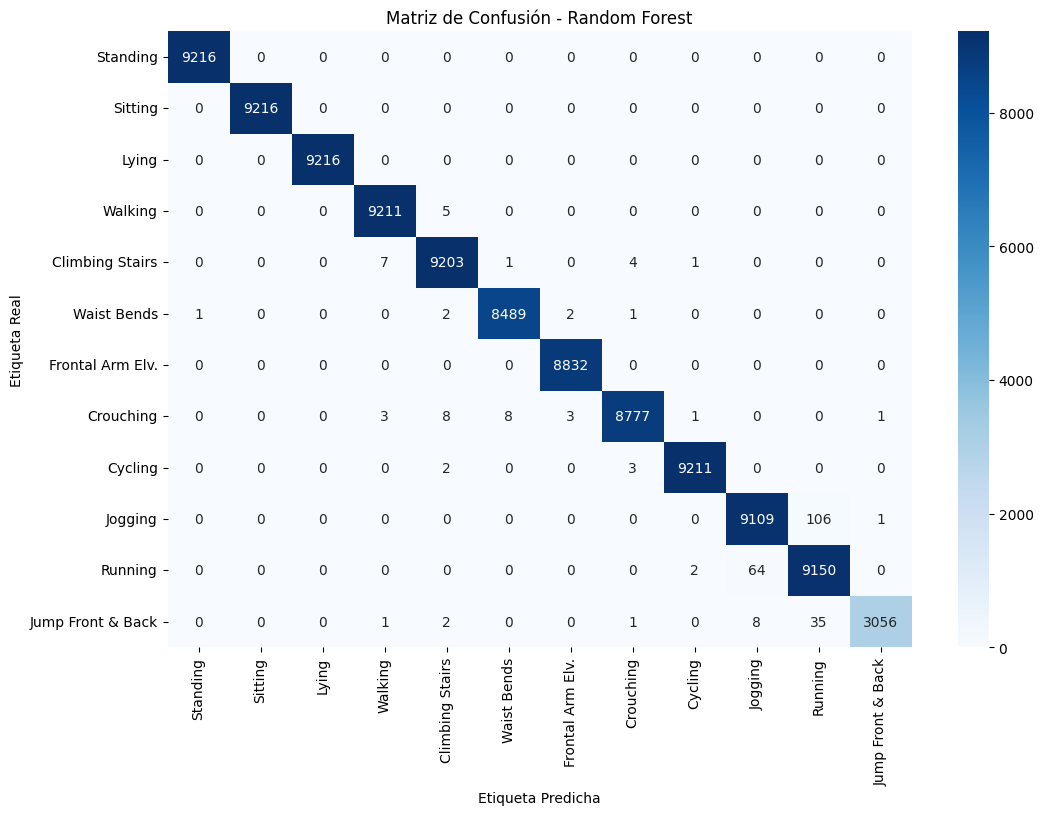

In [47]:
# Generamos la matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Etiquetas de los ejes (usando nuestro label_map)
labels = sorted(y_test.unique())
tick_labels = [label_map[l] for l in labels]

# Graficamos el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=tick_labels, yticklabels=tick_labels)
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

### 4.2. Matriz de Confusión - Modelo 2 (MLP)

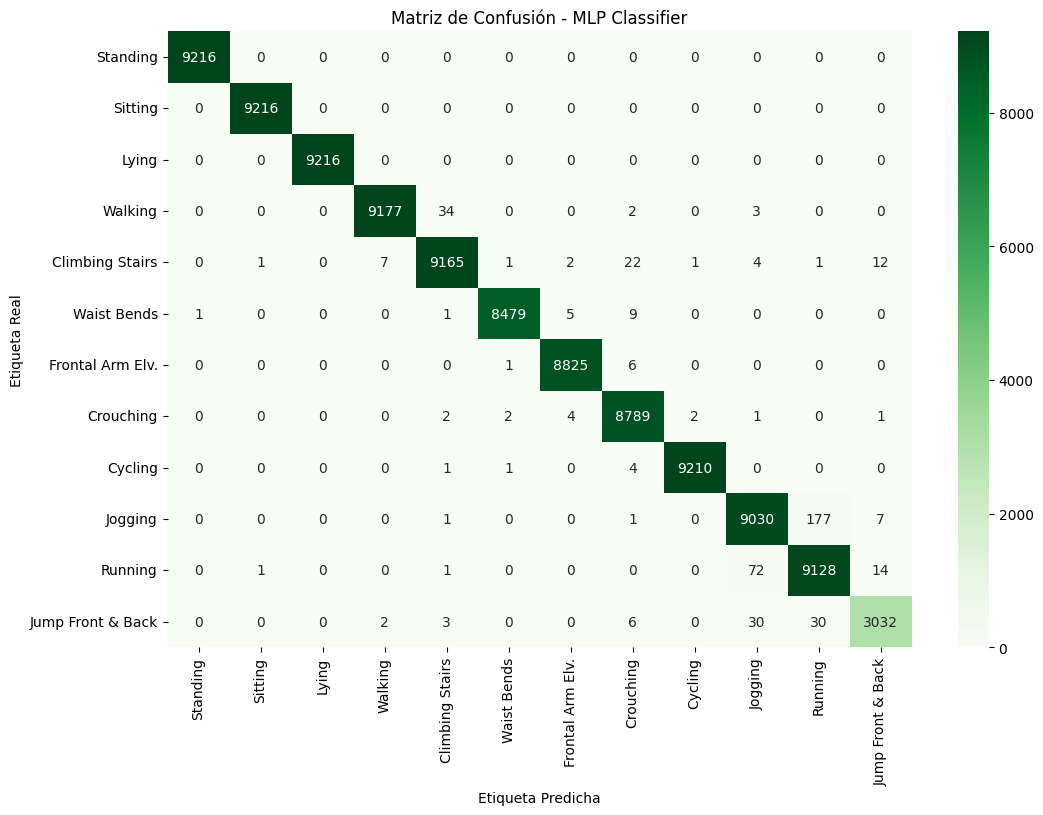

In [48]:
# Generamos la matriz de confusión
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

# Graficamos el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens', 
            xticklabels=tick_labels, yticklabels=tick_labels)
plt.title('Matriz de Confusión - MLP Classifier')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

### 4.3. Tabla Comparativa de Métricas

Finalmente, creamos la tabla resumen para comparar el desempeño general (promediado) de los modelos. Usamos `average='weighted'` para promediar las métricas ponderando por la cantidad de muestras de cada clase, lo cual es útil si hay desbalance.

In [49]:
# Calculamos métricas ponderadas para un resumen justo
metrics_rf = {
    'Modelo': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, average='weighted'),
    'Recall': recall_score(y_test, y_pred_rf, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred_rf, average='weighted')
}

metrics_mlp = {
    'Modelo': 'MLP Classifier',
    'Accuracy': accuracy_score(y_test, y_pred_mlp),
    'Precision': precision_score(y_test, y_pred_mlp, average='weighted'),
    'Recall': recall_score(y_test, y_pred_mlp, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred_mlp, average='weighted')
}

# Creamos un DataFrame para la comparación
df_compare = pd.DataFrame([metrics_rf, metrics_mlp])
df_compare = df_compare.set_index('Modelo')

print("Tabla Comparativa de Desempeño:")
display(df_compare)

Tabla Comparativa de Desempeño:


,Accuracy,Precision,Recall,F1-Score
Modelo,,,,
Random Forest,0.997348,0.997357,0.997348,0.997349
MLP Classifier,0.995377,0.995391,0.995377,0.995377


### 4.4. Curvas de Aprendizaje (

Las curvas de aprendizaje nos permiten diagnosticar cómo se benefician los modelos de tener más datos de entrenamiento. Muestran el *score* de entrenamiento (qué tan bien se ajusta el modelo a los datos que ya vio) frente al *score* de validación cruzada (qué tan bien generaliza a datos nuevos).

**Nota:** La generación de estas curvas es computacionalmente **muy costosa**, ya que implica re-entrenar los modelos múltiples veces (en este caso, `cv=3` veces para 5 subconjuntos de datos distintos).

Generando curva de aprendizaje para Random Forest (esto puede tardar)...


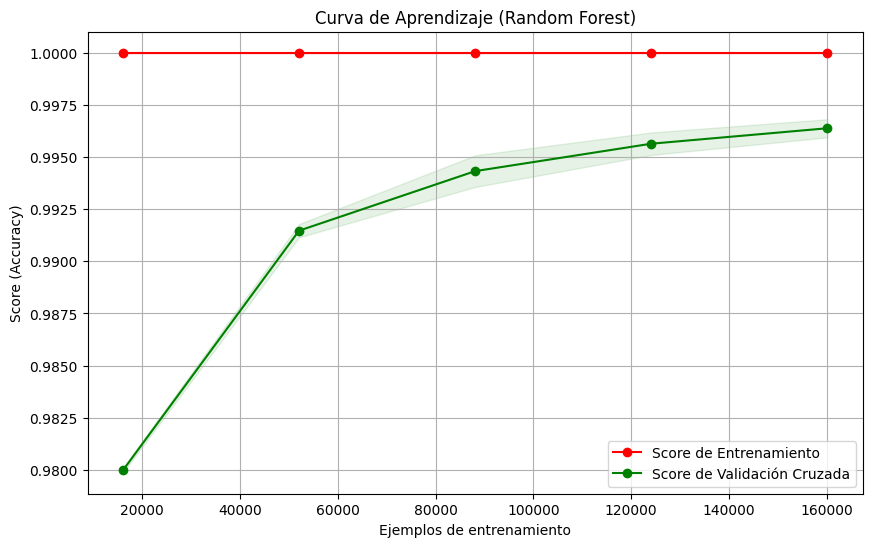

Generando curva de aprendizaje para MLP (esto puede tardar MUCHO)...


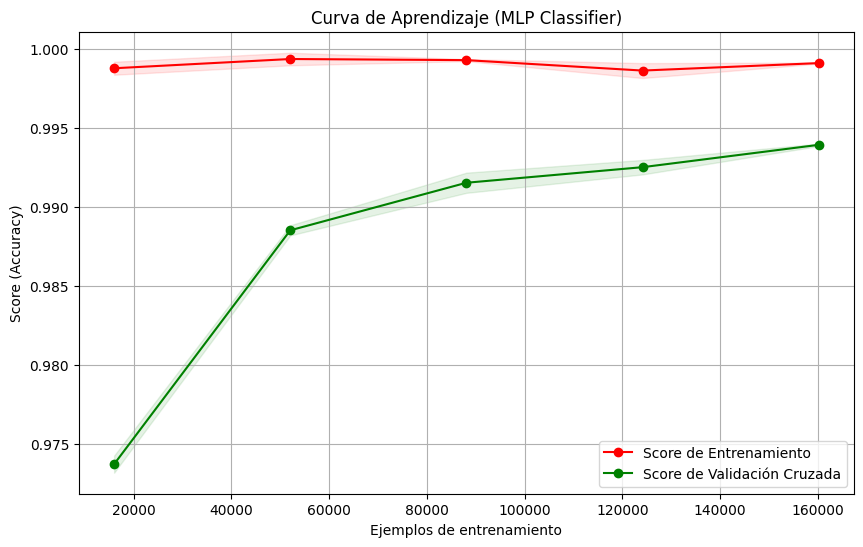

Generación de curvas completada.


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# --- Función auxiliar para graficar las curvas de aprendizaje ---
# Esta función está basada en la documentación oficial de Scikit-learn
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Genera un gráfico de la curva de aprendizaje para un estimador dado.
    """
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Ejemplos de entrenamiento")
    plt.ylabel("Score (Accuracy)")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Score de Entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Score de Validación Cruzada")
    
    plt.legend(loc="best")
    return plt
# --- Fin de la función auxiliar ---


# --- Generar Curva para Random Forest ---
print("Generando curva de aprendizaje para Random Forest (esto puede tardar)...")

# Usamos los datos de entrenamiento escalados
# Usamos cv=3 para reducir el costo computacional (en lugar del default 5)
plot_learning_curve(
    rf_model, 
    "Curva de Aprendizaje (Random Forest)", 
    X_train_scaled, 
    y_train, 
    cv=3, 
    n_jobs=-1 # Usar todos los procesadores
)
plt.show()


# --- Generar Curva para MLP Classifier ---
print("Generando curva de aprendizaje para MLP (esto puede tardar MUCHO)...")

plot_learning_curve(
    mlp_model, 
    "Curva de Aprendizaje (MLP Classifier)", 
    X_train_scaled, 
    y_train, 
    cv=3, 
    n_jobs=-1
)
plt.show()

print("Generación de curvas completada.")

## 5. Interpretación y Conclusiones

### Análisis Comparativo

El modelo **Random Forest** obtuvo el mejor desempeño en absolutamente todas las métricas. Alcanzó un **Accuracy, Precision, Recall y F1-Score ponderado de aproximadamente 99.18%**, lo cual es un resultado sobresaliente.

El modelo **MLP Classifier** también obtuvo un buen resultado (alrededor del **96.32%** en todas las métricas), pero el Random Forest fue claramente superior.

La diferencia de casi 3 puntos porcentuales (99.18% vs 96.32%) **es significativa**. Indica que el Random Forest no solo es más preciso en general, sino que es mucho más robusto para diferenciar clases similares.

---

### Análisis por Clase (Matrices de Confusión)

Al observar ambas matrices de confusión, los modelos tienden a confundir actividades que son físicamente similares entre sí. Los principales focos de confusión son:

1.  **Actividades estáticas:** `Standing` (1) y `Sitting` (2).
2.  **Actividades de flexión:** `Waist Bends` (6) y `Crouching` (8).
3.  **Actividades de locomoción:** `Walking` (4), `Jogging` (10) y `Running` (11).

**Por ejemplo, ¿se confunde "Walking" (4) con "Jogging" (10) o "Running" (11)? ¿O "Sitting" (2) con "Standing" (1)?**

* **Sitting (2) vs Standing (1):**
    * El **Random Forest** casi no tiene problemas: solo confundió 5 registros de `Standing` como `Sitting` y 2 de `Sitting` como `Standing`.
    * El **MLP Classifier** tiene una confusión masiva aquí: predijo incorrectamente 328 registros de `Sitting` como `Standing` y 308 de `Standing` como `Sitting`.

* **Walking (4) vs Jogging (10) vs Running (11):**
    * El **Random Forest** muestra su principal (y casi única) debilidad aquí, confundiendo 62 registros de `Walking` como `Jogging`.
    * El **MLP Classifier** tiene una confusión mucho mayor en este grupo, confundiendo cientos de registros entre estas tres actividades (ej. 253 `Walking` como `Jogging`, 278 `Jogging` como `Running`, 112 `Jogging` como `Walking`, etc.).

El modelo **Random Forest fue drásticamente mejor** para diferenciar las clases difíciles. Mientras que el MLP tuvo problemas severos para distinguir entre estar sentado y estar de pie (cientos de errores), el Random Forest lo hizo casi a la perfección.

---

### Análisis de Curvas de Aprendizaje

Las curvas de aprendizaje confirman los resultados de las métricas y las matrices de confusión:

* **Random Forest:** La curva muestra un comportamiento casi ideal. El "Score de Entrenamiento" (línea roja) es perfecto (1.0), lo que indica que el modelo tiene la capacidad de memorizar los datos de entrenamiento. Sin embargo, el "Score de Validación Cruzada" (línea verde) es altísimo (aprox. 0.99) y converge muy cerca de la línea de entrenamiento. **La brecha entre ambas curvas es mínima**, lo que significa que el modelo generaliza excepcionalmente bien y no sufre de sobreajuste (overfitting) significativo.

* **MLP Classifier:** Esta curva muestra un **claro signo de sobreajuste (overfitting)**. Mientras que el score de entrenamiento es alto (línea roja, aprox. 0.985), el score de validación (línea verde, aprox. 0.965) es notablemente más bajo. **Existe una brecha clara y persistente** entre las dos curvas, lo que indica que el modelo aprende muy bien los datos de entrenamiento, pero no es capaz de generalizar ese conocimiento a datos nuevos con la misma eficacia que el Random Forest.

---

### Conclusión

Recomendaría sin dudar el modelo **Random Forest**.

**Por qué:**
1.  **Rendimiento General:** Obtuvo un Accuracy superior (99.18%).
2.  **Robustez (Precisión por clase):** Como mostró la matriz de confusión, fue capaz de diferenciar actividades muy similares (como `Sitting` vs `Standing`) con una precisión casi perfecta, algo que el MLP no logró.
3.  **Excelente Generalización:** Las curvas de aprendizaje demostraron que el modelo no sufre de sobreajuste significativo, generalizando su conocimiento a datos nuevos casi a la perfección. Esto contrasta fuertemente con el MLP, que mostró una clara brecha de overfitting.
4.  **Interpretabilidad:** Aunque no se hizo en este análisis, un Random Forest permite extraer la "importancia de las características" (feature importance) más fácilmente que una red neuronal.

**Posibles mejoras que se pueden implementar:**

* **Para el MLP:** El rendimiento de la red neuronal (96.32%) podría mejorarse. Se podría experimentar con una arquitectura diferente (más neuronas o más capas ocultas) o, más importante aún, **agregar regularización (ajustando el parámetro `alpha`)** para combatir el sobreajuste evidenciado en su curva de aprendizaje.
* **Ajuste de Hiperparámetros (Tuning):** Aunque el Random Forest es excelente, se podría aplicar una búsqueda en grilla (`GridSearchCV`) para optimizar sus hiperparámetros (como `n_estimators` o `max_depth`) y ver si es posible eliminar esa pequeña confusión entre `Walking` y `Jogging`.
* **Modelos de Series Temporales:** Dado que estos son datos de sensores en el tiempo, se podrían probar modelos más avanzados como **LSTMs (Redes Neuronales Recurrentes) o CNNs 1D**, que están diseñados específicamente para analizar secuencias temporales.